<a href="https://colab.research.google.com/github/jimmyzhang2003/COVIDStatusPrediction/blob/main/COVID_Status_Prediction_Analysis_and_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/

/content/drive/My Drive


In [ ]:
import pandas as pd     
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns
sns.set()

In [ ]:
import os
path_to_data = 'MSSM_COVID_FINAL/UPDATED_DATASETS/'
files = []
for file in os.listdir(path_to_data):
  if file.endswith('.txt'):
    files.append(file)

print(files)

##use 0413_TESTED_0602_UPDATE as train data
patient_df = pd.read_csv(path_to_data + files[0], sep="\t", 
                        error_bad_lines=False, encoding='latin1')

#use 0602_TESTED_MINUS0413 as test data
test_df = pd.read_csv(path_to_data + files[1], sep="\t", 
                        error_bad_lines=False, encoding='latin1')

['0413_TESTED_0602_UPDATE.txt', '0602_TESTED_MINUS0413.txt', '0805_OUTPATIENT_ADULTS_TESTED.txt', '0602_ML_PREDICTIONS.txt', '0413_ML_PREDICTIONS.txt']


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
"There are {} features in the train dataset.".format(patient_df.shape[1])

'There are 125 features in the train dataset.'

In [ ]:
print('0413 Dataset Dimensions: {}'.format(patient_df.shape))
print('0602 Dataset Dimensions: {}'.format(test_df.shape))

0413 Dataset Dimensions: (12476, 125)
0602 Dataset Dimensions: (19263, 125)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


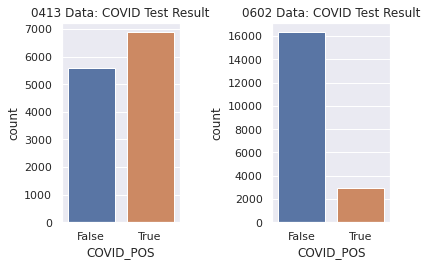

In [ ]:
#check distribution of target outcomes in 0413 (train) and 0602 (test) datasets
fig, ax = plt.subplots(1,2)
sns.countplot(patient_df['COVID_POS'], ax = ax[0]).set_title('0413 Data: COVID Test Result')
sns.countplot(test_df['COVID_POS'], ax = ax[1]).set_title('0602 Data: COVID Test Result')
fig.tight_layout(pad = 1.5)
fig.show()

In [ ]:
print(patient_df.COVID_POS.value_counts())
print(test_df.COVID_POS.value_counts())

True     6884
False    5592
Name: COVID_POS, dtype: int64
False    16323
True      2940
Name: COVID_POS, dtype: int64


In [ ]:
#drop variables irrelevant to COVID test result and any overlapping variables
out_cols = ['NEW_MASKED_MRN', 'NEW_MASKED_ENCOUNTER_EPIC_CSN', 'MASKED_MRN',
       'MASKED_ENCOUNTER_EPIC_CSN', 'ENC_SEQ_NUMBER','MASKED_EXTERNAL_VISIT_ID', 'ENC_ACUITY','COVID_RESULT', 
       'COVID_ORDER_DAYS_SINCE_ENCOUNTER', 'DISCHARGE_DAYS_SINCE_ENCOUNTER', 'PREFERREDLANGUAGE', 'FACILITY',
       'INFECTION_STATUS', 'ENCOUNTER_TYPE', 'ADMISSION_TYPE', 'PATIENT_CLASS', 'LOCATION_OF_CARE', 'DEPARTMENT_NAME',
       'CARE_AREA_TYPE', 'EMERGENCY_DEPARTMENT', 'INPATIENT_NON_ICU', 'ICU', 'DISCHARGE_LOCATON', 'COVID_ORDER',
       'COVID_RESULT_DAYS_SINCE_ENCOUNTER','CANCER_DIAGNOSIS_DESCRIPTION', 'DECEASED_INDICATOR', 
       'DECEASED_DAYS_SINCE_ENCOUNTER', 'TOCILIZUMAB', 'DATE_OF_FIRST_TOCILIZUMAB', 'REMDESIVIR',
       'DATE_OF_FIRST_REMDESIVIR', 'SARILUMAB', 'DATE_OF_FIRST_SARILUMAB','HYDROXYCHLOROQUINE', 
       'DATE_OF_FIRST_HYDROXYCHLOROQUINE','ANAKINRA', 'DATE_OF_FIRST_ANAKINRA', 'AZITHROMYCIN',
       'DATE_OF_FIRST_AZITHROMYCIN', 'INITIAL_AIRWAY_TYPE','INITIAL_AIRWAY_DATE', 'RUN_DATE','ADMITTED', 'COPD_ASTHMA', 
       'INHOSP_DEATH', 'DAYS_TO_INHOSPDEATH_DISCHARGE','ZIPCODE', 'RACE_ETHNICITY_COMBINED']

patient_df_modified = patient_df.copy().drop(columns = out_cols, axis = 1)

#repeat for test set
test_df_modified = test_df.copy().drop(columns = out_cols, axis = 1)

In [ ]:
"There are {} features left in the patient dataset.".format(patient_df_modified.shape[1])

'There are 76 features left in the patient dataset.'

In [ ]:
#drop columns with >90% missing data
patient_df_modified = patient_df_modified.dropna(thresh = 0.3*patient_df_modified.shape[0], axis = 1)

In [ ]:
#label encode SEX variable and rename to MALE
patient_df_modified['SEX'] = patient_df_modified['SEX'].map({'MALE': 1, 'FEMALE':0})
patient_df_modified.rename(columns={'SEX': 'MALE'}, inplace=True)
test_df_modified['SEX'] = test_df_modified['SEX'].map({'MALE': 1, 'FEMALE':0})
test_df_modified.rename(columns={'SEX': 'MALE'}, inplace=True)

In [ ]:
#label encode SMOKING_SIMPLE variable
patient_df_modified['SMOKING_SIMPLE'] = patient_df_modified['SMOKING_SIMPLE'].map({'NEVER': 0, 'FORMER':1, 'CURRENT':2})
test_df_modified['SMOKING_SIMPLE'] = test_df_modified['SMOKING_SIMPLE'].map({'NEVER': 0, 'FORMER':1, 'CURRENT':2})

In [ ]:
#modifying the object values into categorical data 
cols_str = []
for col in patient_df_modified.columns: 
  if patient_df_modified[col].dtype == object:
    cols_str.append(col)

for col in cols_str: 
 patient_df_modified[col] = pd.Categorical(patient_df_modified[col]).codes
 test_df_modified[col] = pd.Categorical(test_df_modified[col]).codes
 patient_df_modified[col] = patient_df_modified[col].replace(-1, np.nan) ##replace -1s with nan
 test_df_modified[col] = test_df_modified[col].replace(-1, np.nan) 
print(cols_str)

['RACE_SIMPLE']


In [ ]:
patient_df_modified.head()

,COVID_POS,AGE,MALE,ASTHMA,COPD,HTN,OBSTRUCTIVE_SLEEP_APNEA,OBESITY,DIABETES,CHRONIC_KIDNEY_DISEASE,HIV_FLAG,CANCER_FLAG,CORONARY_ARTERY_DISEASE,ATRIAL_FIBRILLATION,HEART_FAILURE,CHRONIC_VIRAL_HEPATITIS,ALCOHOLIC_NONALCOHOLIC_LIVER_DISEASE,ARDS,ACUTE_KIDNEY_INJURY,ACUTE_VENOUS_THROMBOEMBOLISM,CEREBRAL_INFARCTION,INTRACEREBRAL_HEMORRHAGE,BMI,TEMPERATURE,TEMP_MAX,HEART_RATE,RESPIRATORY_RATE,SYSTOLIC_BP,DIASTOLIC_BP,O2_SAT,O2SAT_MIN,RACE_SIMPLE,SMOKING_SIMPLE,ALBUMIN,ALT,ANC,AST,BASO_PCT,BUN,CALCIUM,CHLORIDE,CREATININE,EOS_PCT,HGB,LYMPHS_PCT,MONO_PCT,NEUTRO_PCT,PLT,POTASSIUM,SODIUM,TBILI,WBC
0,False,59,1.0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN,96.0,96.0,83.0,NaN,NaN,NaN,97.0,97.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,40,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,98.0,98.6,130.0,20.0,137.0,97.0,100.0,100.0,NaN,NaN,5.0,20.0,2.4,27.0,1.4,14.0,9.7,102.0,0.82,0.9,13.2,40.3,6.1,51.3,314.0,4.2,NaN,0.5,4.7
2,False,52,1.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,25.32,98.1,98.1,91.0,NaN,96.0,63.0,95.0,95.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,False,28,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26.14,98.9,98.9,61.0,16.0,127.0,72.0,99.0,99.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,False,27,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24.28,99.0,99.5,90.0,18.0,112.0,85.0,97.0,97.0,3.0,0.0,NaN,NaN,NaN,NaN,0.4,NaN,NaN,NaN,NaN,0.1,13.8,14.2,6.6,78.7,210.0,NaN,NaN,NaN,9.6


In [ ]:
#remove variables that are not present in both datasets
patient_df_modified, test_df_modified = patient_df_modified.align(test_df_modified, join = 'inner', axis =1)

In [ ]:
#convert target variable (COVID_POS) values from True/False to 1/0
patient_df_modified['COVID_POS'] *= 1
test_df_modified['COVID_POS'] *= 1

In [ ]:
"There are {} features remaining.".format(patient_df_modified.shape[1])

'There are 52 features remaining.'

In [ ]:
print('{} NAs in COVID_POS train data'.format(patient_df_modified['COVID_POS'].isnull().sum()))
print('{} NAs in COVID_POS test data'.format(test_df_modified['COVID_POS'].isnull().sum()))

0 NAs in COVID_POS train data
0 NAs in COVID_POS test data


In [ ]:
## impute missing values
from sklearn.impute import SimpleImputer

patient_df_modified_imputed = patient_df_modified.copy()
test_df_modified_imputed = test_df_modified.copy()
cat_cols = [col for col in patient_df_modified.columns if patient_df_modified[col].nunique() < 5 and col != 'COVID_POS'] #exclude target variable
num_cols = [col for col in patient_df_modified_imputed.columns if col not in cat_cols and col != 'COVID_POS']

#impute by median for numerical columns
for col in num_cols:
  imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
  values = patient_df_modified_imputed[col].values.reshape(-1,1)
  transformed_values = imputer.fit_transform(values)
  patient_df_modified_imputed[col] = transformed_values

#impute by most frequent value for categorical columns
for col in cat_cols:
  imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
  values = patient_df_modified_imputed[col].values.reshape(-1,1)
  transformed_values = imputer.fit_transform(values)
  patient_df_modified_imputed[col] = transformed_values

#repeat for test set
for col in num_cols:
  imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
  values = test_df_modified_imputed[col].values.reshape(-1,1)
  transformed_values = imputer.fit_transform(values)
  test_df_modified_imputed[col] = transformed_values  

for col in cat_cols:
  imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
  values = test_df_modified_imputed[col].values.reshape(-1,1)
  transformed_values = imputer.fit_transform(values)
  test_df_modified_imputed[col] = transformed_values

In [ ]:
!pip install eli5

     |████████████████████████████████| 112kB 2.7MB/s 


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report, roc_curve, auc
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, SelectPercentile

import eli5
from eli5.sklearn import PermutationImportance
from IPython.core.display import display, HTML

import xgboost as xgb
from xgboost import XGBClassifier
from scipy import sparse, stats

import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

class TrainClassifier(BaseEstimator):
    
    def __init__(self, classifier=XGBClassifier(objective ='binary:logistic', tree_hist='gpu_hist', seed=np.random.seed(32))):
        self.classifier = classifier 
    
    def fit(self, X, y=None, **kwargs): 
        self.classifier.fit(X, y)
        return self 

    #randomized search optimization for xgb classifier
    def rs_tune_xgb(self, n_iter, num_folds, X, y, singletree = False):
      folds = StratifiedKFold(n_splits = num_folds, shuffle = False)
      params = {'n_estimators': stats.randint(100, 500),
              'learning_rate': stats.uniform(0.01, 0.4),
              'subsample': stats.uniform(0.2, 1.0),
              'max_depth': stats.randint(1,40),
              'colsample_bytree': stats.uniform(0.2, 1.0),
              'min_child_weight': stats.randint(1,20),
              'gamma': [0, 0.01, 0.1, 0.2 , 0.3, 1, 3, 5, 10],
              }

      if singletree:
          params.pop('n_estimators')   
          params.pop('max_depth')

      optimized_model = RandomizedSearchCV(estimator = self.classifier, 
                                           param_distributions = params,
                                           n_iter = n_iter,
                                           scoring = 'roc_auc',
                                           cv = folds,
                                           random_state = np.random.seed(20),
                                           n_jobs = -1,
                                           verbose = 2)
      optimized_model.fit(X, y)
      self.classifier = optimized_model.best_estimator_
      print("Optimal Parameters: {}".format(optimized_model.best_params_))

    #randomized search optimization for RF classifier
    def rs_tune_rf(self, n_iter, num_folds, X, y):
      folds = StratifiedKFold(n_splits = num_folds, shuffle = False)
      params =  {'max_features': ['auto', 'sqrt'],
                 'min_samples_split': [2, 5, 10],
                 'min_samples_leaf': [1, 2, 4],
                 'n_estimators': [int(x) for x in np.linspace(start=100, stop=500, num=20)], 
                 'max_depth': [int(x) for x in np.linspace(start=5, stop=40, num=8)],
                 'bootstrap': [True, False]}
      optimized_model = RandomizedSearchCV(estimator = self.classifier,
                                           param_distributions = params,
                                           n_iter = n_iter,
                                           scoring = 'roc_auc',
                                           cv = folds,
                                           random_state = np.random.seed(21),
                                           n_jobs = -1,
                                           verbose = 2)
      optimized_model.fit(X,y)
      self.classifier = optimized_model.best_estimator_
      print("Optimal Parameters: {}".format(optimized_model.best_params_))

    #randomized search optimization for logistic regression classifier
    def rs_tune_logit(self, n_iter, num_folds, X, y):
      folds = StratifiedKFold(n_splits = num_folds, shuffle = False)
      params =  {'C': np.logspace(-4, 4, num = 20),
                 'penalty': ['l1', 'l2', 'elasticnet'],
                 'solver': ['liblinear', 'saga'],
                 'max_iter': [1, 10, 100, 200, 400, 500, 1000, 1500, 2000, 3000, 4000, 5000]
                 }
      optimized_model = RandomizedSearchCV(estimator = self.classifier,
                                           param_distributions = params,
                                           n_iter = n_iter,
                                           scoring = 'roc_auc',
                                           cv = folds,
                                           random_state = np.random.seed(22),
                                           n_jobs = -1,
                                           verbose = 2)
      optimized_model.fit(X,y)
      self.classifier = optimized_model.best_estimator_
      print("Optimal Parameters: {}".format(optimized_model.best_params_))

    #1st method of feature extraction 
    def permutationImportances(self, model, dataset, X, y=None, display=False):   
      model = model.fit(X, y)
      perm = PermutationImportance(model, random_state=99).fit(X, y)
      perm_df = eli5.format_as_dataframe(eli5.explain_weights(perm, feature_names=X.columns.tolist()))
      if display: 
        display(eli5.show_weights(perm, feature_names=X.columns.tolist(), top=20))
      perm_df_filtered = perm_df[perm_df['weight'] >= 0]
      dataset_filtered = dataset[list(perm_df_filtered['feature'])]
      return dataset_filtered

    #2nd method of feature extraction
    def rfcImportancesPlot(self, data, model): 
      important_features = data.columns
      importances = model.feature_importances_
      idx = np.argsort(importances)

      plt.figure(figsize=(20, 20))
      plt.title('Random Forests Feature Importances')
      x, y = range(len(idx)), importances[idx]
      plt.barh(x, y, color='b', align='center')
      plt.yticks(x, [important_features[i] for i in idx])
      plt.show()
    
    def rfcSelectPercentile(self, model, X_train, X_test, y_train, y_test, display=True):
      sfm = SelectPercentile(percentile=10)
      sfm.fit_transform(X_train, y_train)

      columns = np.asarray(X_train.columns.values)
      support = np.asarray(sfm.get_support())
      cols_with_support = columns[support]
      X_train_transformed = pd.DataFrame(sfm.transform(X_train), columns=cols_with_support)
      X_test_transformed = pd.DataFrame(sfm.transform(X_test), columns =cols_with_support)

      if display:
        self.rfcImportancesPlot(X_train, model)
      return X_train_transformed, X_test_transformed 

    #3rd method of feature extraction 
    def varianceThresholding(self, dataset, X_train, X_test):
        variance = dataset.var()
        avg_variance = np.average(variance)
        v_thresh = VarianceThreshold(threshold=avg_variance)
        v_thresh.fit(X_train)
        return X_train[X_train.columns[v_thresh.get_support(indices = True)]], X_test[X_test.columns[v_thresh.get_support(indices = True)]]

    #4th method of feature extraction 
    def highCorrelation(self, dataset):
      correlation_matrix = dataset.corr().abs()
      upper_triangle = np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool8)
      select_ut = correlation_matrix.where(upper_triangle)
      hc = [col for col in dataset.columns if any(select_ut[col] > 0.95)]
      dataset = dataset.drop(columns = hc, axis=1)
      return dataset 
    
    def predict(self, X, y=None):
        self.classifier.predict(X)

    def score(self, X, y):
        testing_predictions = self.classifier.predict(X)
        predictions = [round(value) for value in testing_predictions]
        accuracy = accuracy_score(y, predictions)
        return ("Accuracy: %.2f%%" % (accuracy * 100.0))

    def roc_auc(self, X, y):
        testing_probs = self.classifier.predict_proba(X)
        predictions = testing_probs[:,1]
        fpr, tpr, threshold = roc_curve(y, predictions)
        return ("AUC: %.4f" % (auc(fpr,tpr)))
    
    def cross_val_auc(self, X, y):
        scores = cross_val_score(self.classifier, X, y, cv=5, scoring = 'roc_auc')
        return ("CV AUC: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    def class_report(self, X, y):
        testing_predictions = self.classifier.predict(X)
        predictions = [round(value) for value in testing_predictions]
        return classification_report(y, predictions, digits = 4)

    def full_report(self, X_train, y_train, X_test, y_test):
        print('Train', self.score(X_train, y_train))
        print(self.cross_val_auc(X_train, y_train))
        print('Test', self.score(X_test, y_test))
        print('Train', self.roc_auc(X_train, y_train))
        print('Test', self.roc_auc(X_test, y_test))
        print(self.class_report(X_test, y_test))
    
    def displayPredictionMatrix(self, X_test, y_test):
      unique_labels = [0, 1]
      testing_predictions = self.classifier.predict(X_test)
      seed = np.random.seed(0)
      matrix = confusion_matrix(y_test, testing_predictions, labels=unique_labels)
      sns.heatmap(matrix, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cmap='Blues')
      plt.ylabel('Actual/True Label')
      plt.xlabel('Predicted Label')
      plt.title('Confusion Matrix for Predicted Labeling')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
#use preprocessed 0413 dataset as train and preprocessed 0602 dataset as test
features = [feature for feature in patient_df_modified.columns if feature != "COVID_POS"]

X_train = patient_df_modified[features]
y_train = patient_df_modified['COVID_POS']
X_test = test_df_modified[features]
y_test = test_df_modified['COVID_POS']

In [ ]:
#imputed datasets for RF and logistic models
X_train_imp = patient_df_modified_imputed[features]
X_test_imp = test_df_modified_imputed[features]

In [ ]:
# baseline XGB model (without feature selection or optimization)
tr = TrainClassifier()
tr.fit(X_train, y_train)
tr.full_report(X_train, y_train, X_test, y_test)

Train Accuracy: 76.67%
CV Accuracy: 74.31%
Test Accuracy: 81.97%
Train AUC: 0.8579
Test AUC: 0.7460
              precision    recall  f1-score   support

           0       0.91      0.87      0.89     16323
           1       0.43      0.52      0.47      2940

    accuracy                           0.82     19263
   macro avg       0.67      0.70      0.68     19263
weighted avg       0.84      0.82      0.83     19263



In [ ]:
# baseline RFC model 
tr_rfc = TrainClassifier(classifier=RandomForestClassifier())
tr_rfc.fit(X_train_imp, y_train)
tr_rfc.full_report(X_train_imp, y_train, X_test_imp, y_test)

Train Accuracy: 97.63%
CV Accuracy: 72.38%
Test Accuracy: 83.59%
Train AUC: 0.9976
Test AUC: 0.7496
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     16323
           1       0.46      0.48      0.47      2940

    accuracy                           0.84     19263
   macro avg       0.69      0.69      0.69     19263
weighted avg       0.84      0.84      0.84     19263



In [ ]:
# baseline logistic regression model
tr_logit = TrainClassifier(classifier=LogisticRegression(solver='liblinear'))
tr_logit.fit(X_train_imp, y_train)
tr_logit.full_report(X_train_imp, y_train, X_test_imp, y_test)

Train Accuracy: 72.97%


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CV Accuracy: 72.04%
Test Accuracy: 82.21%
Train AUC: 0.8060
Test AUC: 0.7370
              precision    recall  f1-score   support

           0       0.91      0.88      0.89     16323
           1       0.43      0.49      0.46      2940

    accuracy                           0.82     19263
   macro avg       0.67      0.69      0.68     19263
weighted avg       0.83      0.82      0.83     19263



In [ ]:
#include baseline features for simple models
X_train_simple = X_train[['AGE', 'MALE', 'RACE_SIMPLE', 'ASTHMA', 'COPD', 'HTN', 'OBSTRUCTIVE_SLEEP_APNEA', 
                          'OBESITY', 'DIABETES', 'CHRONIC_KIDNEY_DISEASE', 'HIV_FLAG', 'CANCER_FLAG', 'CORONARY_ARTERY_DISEASE', 
                          'ATRIAL_FIBRILLATION', 'HEART_FAILURE', 'CHRONIC_VIRAL_HEPATITIS', 'ALCOHOLIC_NONALCOHOLIC_LIVER_DISEASE', 
                          'SMOKING_SIMPLE', 'BMI','O2_SAT', 'TEMPERATURE', 'RESPIRATORY_RATE', 'HEART_RATE', 'SYSTOLIC_BP', 'DIASTOLIC_BP',
                          'HGB', 'WBC', 'PLT', 'SODIUM', 'POTASSIUM', 'CHLORIDE', 'BUN', 'CREATININE','ALT', 'AST', 'ALBUMIN', 'CALCIUM', 'TBILI']]
X_test_simple = X_test[X_train_simple.columns]

In [ ]:
#simple multi-tree XGB model
tr_simple = TrainClassifier()

simple_cols = list(X_train_simple2.columns) + ['ALT', 'AST', 'ALBUMIN', 'CALCIUM', 'TBILI']
X_train_simple = X_train[simple_cols]
X_test_simple = X_test[X_train_simple.columns]

tr_simple.rs_tune_xgb(n_iter = 60, num_folds=5, X = X_train_simple, y = y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 21.5min finished


Optimal Parameters: {'colsample_bytree': 0.8952556010790149, 'gamma': 0.1, 'learning_rate': 0.07114811970195446, 'max_depth': 3, 'min_child_weight': 19, 'n_estimators': 355, 'subsample': 0.49414645514677297}


Train Accuracy: 77.56%
CV AUC: 0.82 (+/- 0.09)
Test Accuracy: 77.66%
Train AUC: 0.8587
Test AUC: 0.7467
              precision    recall  f1-score   support

           0     0.9132    0.8137    0.8606     16323
           1     0.3554    0.5704    0.4380      2940

    accuracy                         0.7766     19263
   macro avg     0.6343    0.6921    0.6493     19263
weighted avg     0.8280    0.7766    0.7961     19263



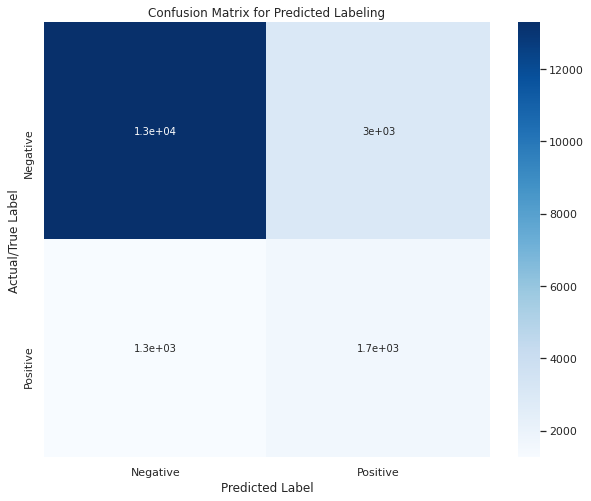

In [ ]:
tr_simple.fit(X_train_simple, y_train)
tr_simple.full_report(X_train_simple, y_train, X_test_simple, y_test)
plt.figure(figsize = (10,8))
tr_simple.displayPredictionMatrix(X_test_simple, y_test)
plt.show()

In [ ]:
#simple random forest model
X_train_simple_imp = X_train_imp[X_train_simple.columns]
X_test_simple_imp = X_test_imp[X_train_simple_imp.columns]

tr_simple_rfc = TrainClassifier(classifier=RandomForestClassifier())

tr_simple_rfc.rs_tune_rf(n_iter = 60, num_folds = 5, X = X_train_simple_imp, y = y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 22.5min finished


Optimal Parameters: {'n_estimators': 289, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': True}


In [ ]:
tr_simple_rfc.fit(X_train_simple_imp, y_train)
tr_simple_rfc.full_report(X_train_simple_imp, y_train, X_test_simple_imp, y_test)

Train Accuracy: 89.93%
CV AUC: 0.80 (+/- 0.12)
Test Accuracy: 79.10%
Train AUC: 0.9696
Test AUC: 0.7453
              precision    recall  f1-score   support

           0     0.9094    0.8367    0.8715     16323
           1     0.3721    0.5371    0.4396      2940

    accuracy                         0.7910     19263
   macro avg     0.6407    0.6869    0.6556     19263
weighted avg     0.8274    0.7910    0.8056     19263



In [ ]:
#simple logistic regression model
tr_simple_logit = TrainClassifier(classifier = LogisticRegression())

tr_simple_logit.rs_tune_logit(n_iter = 60, num_folds = 5, X = X_train_simple_imp, y = y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 76.2min finished


Optimal Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 2000, 'C': 10000.0}


In [ ]:
tr_simple_logit.fit(X_train_simple_imp, y_train)
tr_simple_logit.full_report(X_train_simple_imp, y_train, X_test_simple_imp, y_test)

Train Accuracy: 71.19%
CV AUC: 0.78 (+/- 0.07)
Test Accuracy: 79.05%
Train AUC: 0.7873
Test AUC: 0.7175
              precision    recall  f1-score   support

           0     0.9053    0.8407    0.8718     16323
           1     0.3665    0.5119    0.4272      2940

    accuracy                         0.7905     19263
   macro avg     0.6359    0.6763    0.6495     19263
weighted avg     0.8231    0.7905    0.8039     19263



In [ ]:
#single tree simple XGBoost model
tr_simple_singletree = TrainClassifier(classifier=XGBClassifier(n_estimators=1, max_depth = 4)) #set n_estimators to 1 for single tree 
                                                                                                # set max_depth to 4 for interpretable tree plot
#use same features as other models
tr_simple_singletree.rs_tune_xgb(n_iter = 60, num_folds=5, X = X_train_simple, y = y_train, singletree=True)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    4.0s


Optimal Parameters: {'colsample_bytree': 0.9364286770216461, 'gamma': 1, 'learning_rate': 0.25757493374739976, 'min_child_weight': 17, 'subsample': 0.5949697311980224}


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.8s finished


Train Accuracy: 69.57%
CV AUC: 0.75 (+/- 0.10)
Test Accuracy: 79.37%
Train AUC: 0.7568
Test AUC: 0.6964
              precision    recall  f1-score   support

           0     0.8973    0.8544    0.8753     16323
           1     0.3611    0.4568    0.4034      2940

    accuracy                         0.7937     19263
   macro avg     0.6292    0.6556    0.6393     19263
weighted avg     0.8154    0.7937    0.8033     19263



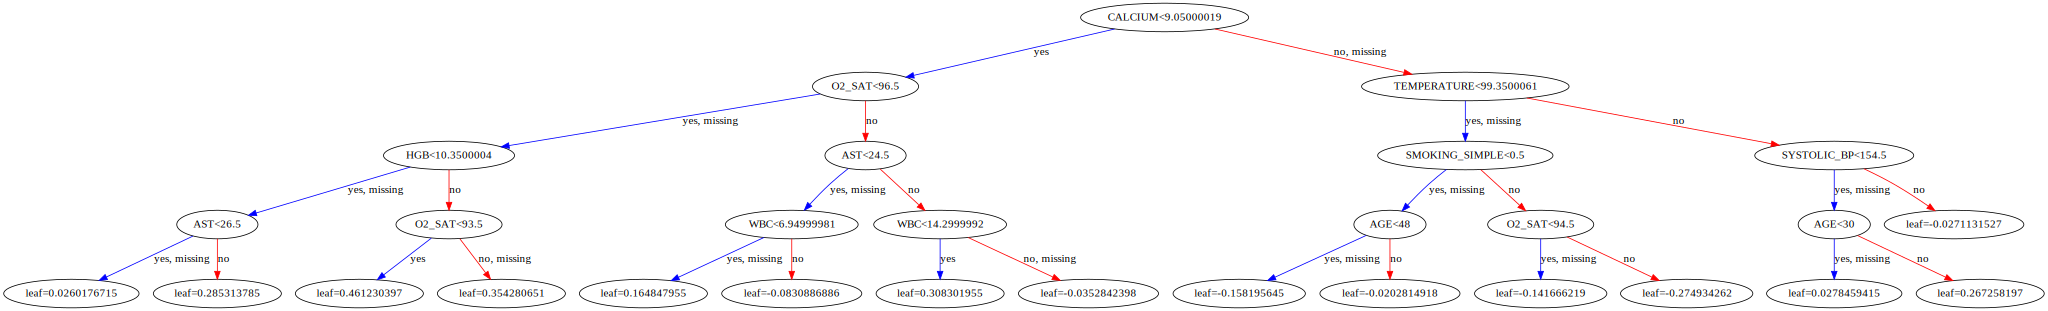

In [ ]:
tr_simple_singletree.fit(X_train_simple, y_train)
tr_simple_singletree.full_report(X_train_simple, y_train, X_test_simple, y_test)

#fig, ax = plt.subplots(figsize=(20,20))
#xgb.plot_tree(tr_simple_singletree.classifier,ax = ax, rankdir="LR")
#plt.show()

xgb.to_graphviz(tr_simple_singletree.classifier)

In [ ]:
#single tree decision tree figure
from graphviz import Source
temp = '''
digraph {
	graph [rankdir=UT pad=0.5 resolution=500 forcelabels=true]
  edge [arrowhead=vee arrowsize=1 fontsize = 6]
  node [margin=0 fontcolor=black fontsize=9 width=0.75 shape=box style="rounded,filled" fillcolor="#fff7eb" margin=0.2]
	0 [label="Calcium < 9.05 mg/dL"]
	0 -> 1 [label="Yes" color="#0000FF"]
	0 -> 2 [label= "No/Missing" color="#FF0000"]
	1 [label="O2 Saturation < 96.5%"]
	1 -> 3 [label="Yes/Missing" color="#0000FF"]
	1 -> 4 [label="No" color="#FF0000"]
	3 [label="Positive" fillcolor = "#29bfc4" fontcolor=white]
	4 [label="Aspartate Aminotransferase < 24.5 u/L"]
	4 -> 7 [label="Yes/Missing" color="#0000FF"]
	4 -> 8 [label= "No" color="#FF0000"]
	7 [label="Lymphocyte Count < 6.95 K/mcL"]
	8 [label="Lymphocyte Count < 14.30 K/mcL"]
  7 -> 11 [label="Yes/Missing" color="#0000FF"]
	7 -> 12 [label= "No" color="#FF0000"]
  8 -> 13 [label="Yes" color="#0000FF"]
	8 -> 14 [label= "No/Missing" color="#FF0000"]
  11 [label="Positive" fillcolor = "#29bfc4" fontcolor=white]
  12 [label="Negative" fillcolor="#910d4f" fontcolor=white]
  13 [label="Positive" fillcolor = "#29bfc4" fontcolor=white]
  14 [label="Negative" fillcolor="#910d4f" fontcolor=white]
	2 [label="Temperature < 99.35°F"]
	2 -> 5 [label="Yes/Missing" color="#0000FF"]
	2 -> 6 [label= "No" color="#FF0000"]
	5 [label="Negative" fillcolor = "#910d4f" fontcolor=white]
	6 [label="Systolic Blood Pressure < 154.5"]
  6 -> 9 [label="Yes/Missing" color="#0000FF"]
  6 -> 10 [label= "No" color="#FF0000"]
  9 [label="Positive" fillcolor = "#29bfc4" fontcolor=white]
  10 [label="Negative" fillcolor="#910d4f" fontcolor=white]
}
'''

s = Source(temp, filename = 'single_tree_xgb_decision_tree.gv', format = 'png')
s.render('single_tree_xgb_decision_tree.gv', view = True)

'single_tree_xgb_decision_tree.gv.png'

In [ ]:
#make dataset with single-tree XGB ML predictions
xgb_test_predictions = tr_simple_singletree.classifier.predict(X_test_simple)
grouped_cols = simple_cols + ['COVID_POS']
X_df = test_df_modified.copy()[grouped_cols]
X_df['PREDICTION'] = xgb_test_predictions

In [ ]:
from sklearn.metrics import plot_roc_curve

def set_roc_plot():
  plt.title('Receiver Operating Characteristic Curve', fontdict = {'weight': 'bold', 'size': 13})
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.ylim([-0.01, 1.01])
  plt.ylabel('True Positive Rate', fontdict={'weight': 'normal', 'size': 12})
  plt.yticks(np.arange(0.0, 1.1, step=0.1))
  plt.xlim([-0.01, 1.01])
  plt.xlabel('False Positive Rate', fontdict={'weight': 'normal', 'size': 12})
  plt.xticks(np.arange(0.0, 1.1, step=0.1)) 

No handles with labels found to put in legend.


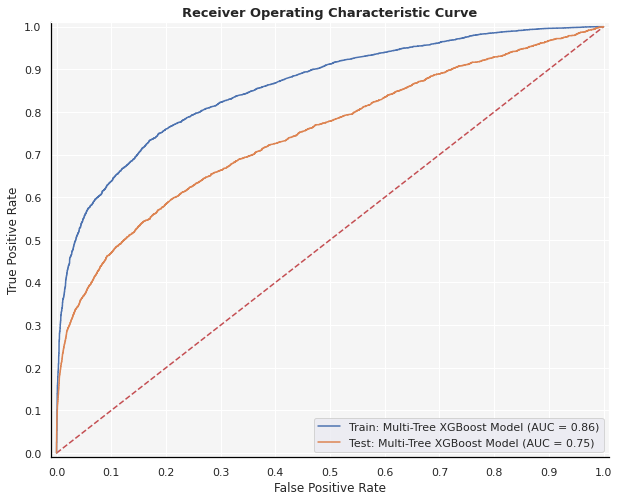

In [ ]:
#ROC curve for multi-tree XGBoost model
xgb_models = [{'label': 'Train: Multi-Tree XGBoost Model', 'classifier': tr_simple.classifier},
              {'label': 'Test: Multi-Tree XGBoost Model', 'classifier': tr_simple.classifier},
              ]

plt.figure(figsize=(10,8))
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.set_facecolor((0.96, 0.96, 0.96))
set_roc_plot()

plot_roc_curve(xgb_models[0]['classifier'], X_train_simple, y_train, ax = ax, name = xgb_models[0]['label'])
plot_roc_curve(xgb_models[1]['classifier'], X_test_simple, y_test, ax = ax, name = xgb_models[1]['label'])

plt.savefig('xgb_roc_train_test.png', dpi = 300)

No handles with labels found to put in legend.


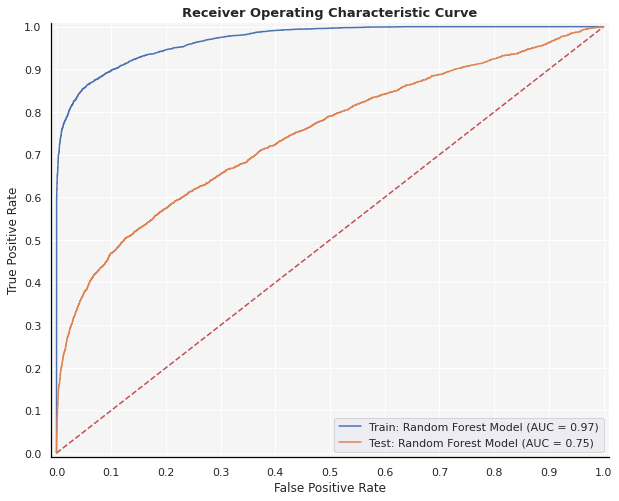

In [ ]:
#ROC curve for random forest model
rfc_models = [{'label': 'Train: Random Forest Model', 'classifier': tr_simple_rfc.classifier},
              {'label': 'Test: Random Forest Model', 'classifier': tr_simple_rfc.classifier},
         ]

plt.figure(figsize=(10,8))
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.set_facecolor((0.96, 0.96, 0.96))
set_roc_plot()

plot_roc_curve(rfc_models[0]['classifier'], X_train_simple_imp, y_train, ax = ax, name = rfc_models[0]['label'])
plot_roc_curve(rfc_models[1]['classifier'], X_test_simple_imp, y_test, ax = ax, name = rfc_models[1]['label'])

plt.savefig('rf_roc_train_test.png', dpi = 300)

No handles with labels found to put in legend.


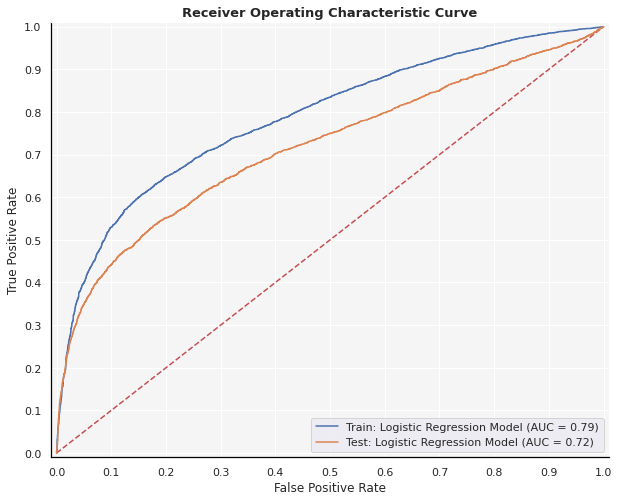

In [ ]:
#ROC curve for logistic regression model
logit_models = [{'label': 'Train: Logistic Regression Model', 'classifier': tr_simple_logit.classifier},
          {'label': 'Test: Logistic Regression Model', 'classifier': tr_simple_logit.classifier},
         ]

plt.figure(figsize=(10,8))
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.set_facecolor((0.96, 0.96, 0.96))
set_roc_plot()

plot_roc_curve(logit_models[0]['classifier'], X_train_simple_imp, y_train, ax = ax, name = logit_models[0]['label'])
plot_roc_curve(logit_models[1]['classifier'], X_test_simple_imp, y_test, ax = ax, name = logit_models[1]['label'])

plt.savefig('logistic_roc_train_test.png', dpi = 300)

No handles with labels found to put in legend.


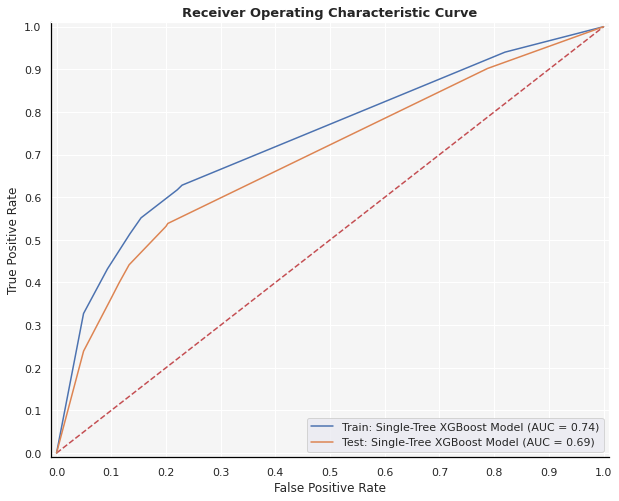

In [ ]:
#ROC curve for single-tree XGBoost model
singletree_xgb_models = [{'label': 'Train: Single-Tree XGBoost Model', 'classifier': tr_simple_singletree.classifier},
          {'label': 'Test: Single-Tree XGBoost Model', 'classifier': tr_simple_singletree.classifier},
         ]

plt.figure(figsize=(10,8))
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.set_facecolor((0.96, 0.96, 0.96))
set_roc_plot()

plot_roc_curve(singletree_xgb_models[0]['classifier'], X_train_simple, y_train, ax = ax, name = singletree_xgb_models[0]['label'])
plot_roc_curve(singletree_xgb_models[1]['classifier'], X_test_simple, y_test, ax = ax, name = singletree_xgb_models[1]['label'])

plt.savefig('singletree_xgb_roc_train_test.png', dpi = 300)

<Figure size 432x288 with 0 Axes>

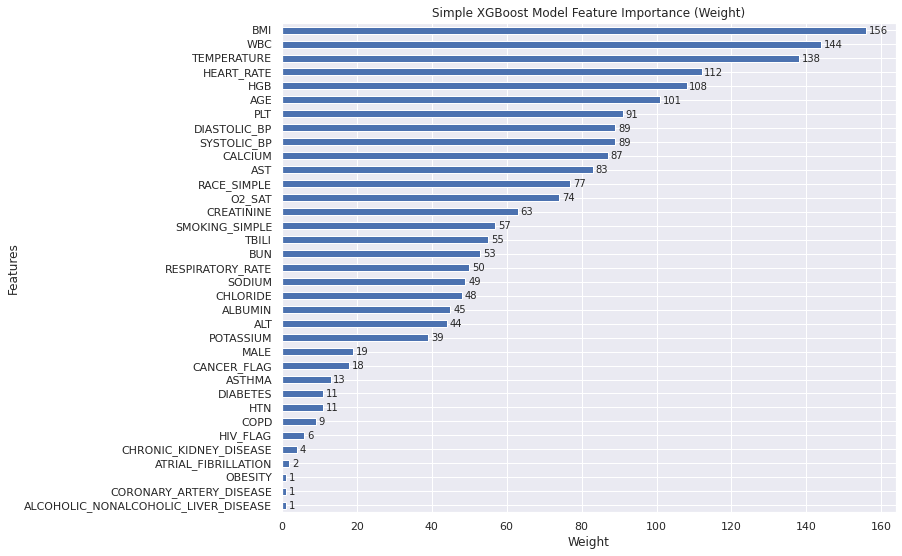

In [ ]:
#multi-tree XGBoost feature importance (by weight)
plt.figure()
weight_scores = tr_simple.classifier.get_booster().get_score(importance_type = 'weight')
weight_df = pd.DataFrame(list(weight_scores.items()), columns = ['Features', 'Weight']).sort_values('Weight', ascending = True)
weight_df.plot(kind='barh', x = 'Features', y='Weight', legend = False, figsize=(11, 9))
for index, value in enumerate(weight_df['Weight']):
    plt.text(value + 0.75, index - 0.25, str(value))
plt.title('Simple XGBoost Model Feature Importance (Weight)')
plt.ylabel('Features')
plt.xlabel('Weight')
plt.show()

<Figure size 432x288 with 0 Axes>

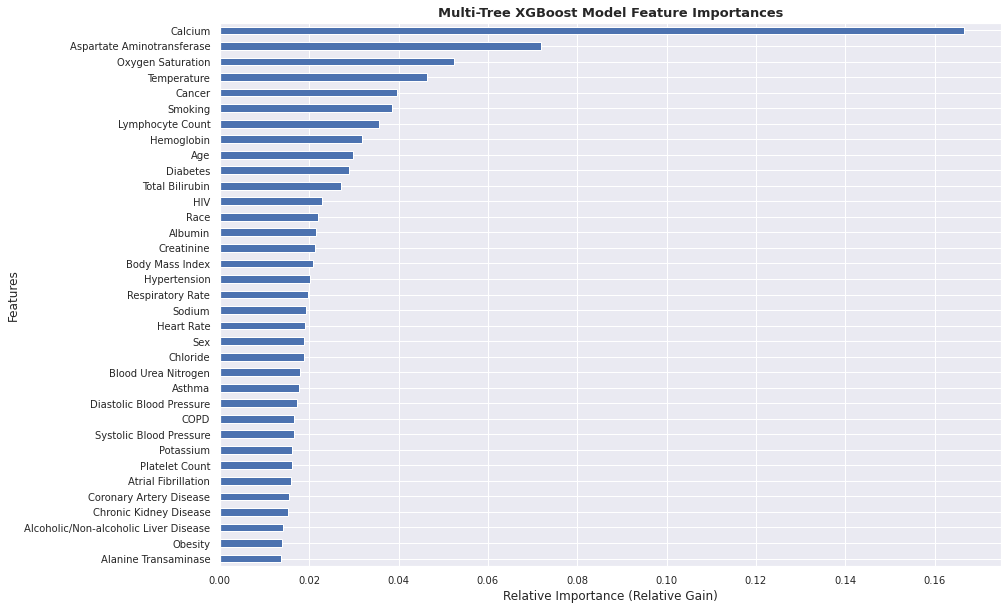

In [ ]:
#multi-tree XGBoost feature importance (by relative gain)
plt.figure()
gain_scores = tr_simple.classifier.get_booster().get_score(importance_type = 'gain')
gain_df = pd.DataFrame(list(gain_scores.items()), columns = ['Features', 'Gain']).sort_values('Gain', ascending = True) 
features_list = ['Alanine Transaminase', 'Obesity', 'Alcoholic/Non-alcoholic Liver Disease', 'Chronic Kidney Disease', 'Coronary Artery Disease',
                 'Atrial Fibrillation', 'Platelet Count', 'Potassium', 'Systolic Blood Pressure', 'COPD', 'Diastolic Blood Pressure', 'Asthma', 
                 'Blood Urea Nitrogen', 'Chloride', 'Sex', 'Heart Rate', 'Sodium', 'Respiratory Rate', 'Hypertension', 'Body Mass Index',
                 'Creatinine', 'Albumin', 'Race','HIV', 'Total Bilirubin', 'Diabetes', 'Age', 'Hemoglobin', 'Lymphocyte Count', 'Smoking',
                 'Cancer', 'Temperature', 'Oxygen Saturation', 'Aspartate Aminotransferase', 'Calcium']
gain_df.Features = features_list
gain_df.Gain /= gain_df.Gain.sum() #get relative gain (gain of each feature / total gain)
gain_df.plot(kind='barh', x = 'Features', y='Gain', legend = False, figsize=(14, 10), fontsize = 10, clip_on = True)
#for index, value in enumerate(round(gain_df['Gain'], 2)):
 #   plt.text(x = value + 0.75, y= index - 0.25, s = str(value), fontdict = {'weight': 'normal', 'size': 10})
plt.title('Multi-Tree XGBoost Model Feature Importances', fontdict = {'weight': 'bold', 'size': 13})
plt.ylabel('Features', fontdict = {'weight': 'normal', 'size': 12})
plt.xlabel('Relative Importance (Relative Gain)', fontdict = {'weight': 'normal', 'size': 12})
plt.savefig('feature_importances_plot.png', bbox_inches = 'tight', dpi = 300)

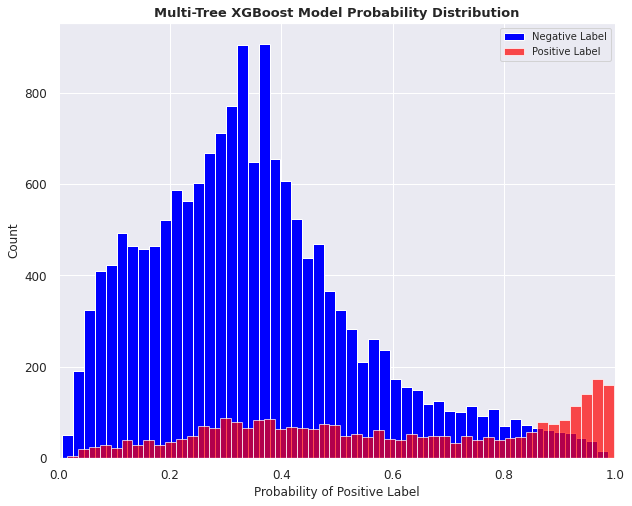

In [ ]:
#plot probability distribution for XGBoost
prediction = tr_simple.classifier.predict_proba(X_test_simple)[:,1]

fig = plt.figure(figsize = (10,8))
plt.title('Multi-Tree XGBoost Model Probability Distribution', fontdict = {'weight': 'bold', 'size': 13})
plt.hist(prediction[y_test==0], bins = 50, label = 'Negative Label', color = 'blue')
plt.hist(prediction[y_test==1], bins = 50, alpha = 0.7, label = 'Positive Label', color = 'red')
plt.xlabel('Probability of Positive Label', fontsize = 12)
plt.ylabel('Count', fontsize =12)
plt.xlim(-0.001, 1.001)
plt.legend(fontsize = 10)
plt.tick_params(axis = 'both', labelsize = 12, pad = 5)
fig.show()

plt.savefig('xgb_probability_distribution.png', dpi =300)

In [ ]:
#get predictions from XGBoost model for antibody comparison 
###NOT USED IN THIS STUDY
tr_simple.fit(X_train_simple, y_train)
xgb_train_predictions = tr_simple.classifier.predict(X_train_simple)
xgb_test_predictions = tr_simple.classifier.predict(X_test_simple)
X_train_simple_preds = patient_df.copy()
X_train_simple_preds['PREDICTION'] = xgb_train_predictions

X_test_simple_preds = test_df.copy()
X_test_simple_preds['PREDICTION'] = xgb_test_predictions

#make new datasets with ML predictions included
X_train_simple_preds.to_csv(path_to_data + '0413_ML_PREDICTIONS.txt', sep="\t", index=False)
X_test_simple_preds.to_csv(path_to_data + '0602_ML_PREDICTIONS.txt', sep="\t", index=False)